In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -r /content/drive/MyDrive/NNTI_Project_files/Project_Files/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"

In [5]:
wandb.init(project="NNTI_Project_task3")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: solankishaique (solankishaique-max-planck-institute-for-informatics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [7]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [8]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
print(dataset['train'].column_names)
print(dataset['train'].to_pandas().head())

['SMILES', 'label']
                                              SMILES  label
0            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
1  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...  -1.18
2             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69
3  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   3.37
4  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   3.10


In [9]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
class SMILESDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = self.prepare_data()

    def prepare_data(self):
        processed_data = []

        for data_point in tqdm(self.dataset):
            encoded_input = self.tokenizer(
                data_point["SMILES"],
                padding="max_length",
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )
            target_tensor = torch.tensor(data_point["label"], dtype=torch.float)
            processed_data.append({
                "input_ids": encoded_input["input_ids"].squeeze(0),
                "attention_mask": encoded_input["attention_mask"].squeeze(0),
                "target": target_tensor
            })
        return processed_data

    def get_data(self):
        return self.data


In [10]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [11]:
# split the data into training and test datasets
# TODO: your code goes here
train_test_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [ ]:
# construct Pytorch data loaders for both train and test datasets
BATCH_SIZE = 16 # adjust based on memory constraints

# TODO: your code goes here
train_dataset = SMILESDataset(train_dataset, tokenizer)
test_dataset = SMILESDataset(test_dataset, tokenizer)
train_data = train_dataset.get_data()
test_data = test_dataset.get_data()

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 840/840 [00:00<00:00, 1951.41it/s]


##Load External Dataset and Diveristy based selection

In [ ]:
external_csv_path = "/content/drive/MyDrive/NNTI_Project_files/Project_Files/tasks/External-Dataset_for_Task2.csv"
external_df = pd.read_csv(external_csv_path)  # Expected columns: "SMILES" and "Label"

In [14]:
class ExternalSMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoded = self.tokenizer(
            row["SMILES"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "target": torch.tensor(row["Label"], dtype=torch.float)
        }
        return item

In [15]:
external_dataset = ExternalSMILESDataset(external_df, tokenizer)
external_loader = DataLoader(external_dataset, batch_size=1, shuffle=False)

In [ ]:
# Load the base model for feature extraction
base_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

In [ ]:
# Define the baseline regression model architecture (as in Task 1)
class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, base_model, hidden_dim=2362):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.base_model = base_model
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        pooled_output = last_hidden_state[:, 0, :]
        return self.regression_head(pooled_output)

def get_fresh_model():
    base_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)
    model = MoLFormerWithRegressionHead(base_model, hidden_dim=2362).to(device)
    return model


In [31]:
def extract_feature(sample, base_model):
    input_ids = sample["input_ids"].unsqueeze(0).to(device)
    attention_mask = sample["attention_mask"].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
        feature = outputs[0][:, 0, :]  # [CLS] token representation
    return feature.squeeze(0).cpu().numpy()


In [ ]:
external_features = []
for i in tqdm(range(len(external_dataset)), desc="Extracting external features"):
    sample = external_dataset[i]
    feat = extract_feature(sample, base_model)
    external_features.append(feat)
external_features = np.array(external_features)
print(f"Extracted features shape: {external_features.shape}")

Extracting external features: 100%|██████████| 300/300 [00:06<00:00, 45.33it/s]

Extracted features shape: (300, 2362)


In [ ]:
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(external_features)
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_


In [34]:
selected_indices = []
for cluster in range(num_clusters):
    indices = np.where(cluster_labels == cluster)[0]
    if len(indices) == 0:
        continue
    cluster_feats = external_features[indices]
    centroid = cluster_centers[cluster]
    distances = np.linalg.norm(cluster_feats - centroid, axis=1)
    best_idx = indices[np.argmin(distances)]
    selected_indices.append(best_idx)
selected_indices = sorted(selected_indices)
print(f"Selected {len(selected_indices)} diverse external samples.")

Selected 100 diverse external samples.


In [ ]:
class SelectedExternalDataset(Dataset):
    def __init__(self, external_dataset, selected_indices):
        self.external_dataset = external_dataset
        self.selected_indices = selected_indices

    def __len__(self):
        return len(self.selected_indices)

    def __getitem__(self, idx):
        actual_idx = self.selected_indices[idx]
        return self.external_dataset[actual_idx]


In [ ]:
selected_external_dataset = SelectedExternalDataset(external_dataset, selected_indices)

In [37]:
selected_external_data_full = [selected_external_dataset[i] for i in range(len(selected_external_dataset))]
print("Total selected external samples:", len(selected_external_data_full))

Total selected external samples: 100


In [ ]:
top_k_values = [100, 80, 60, 40, 20]
selection_results = {}

original_train_data = train_dataset.get_data()

LR = 2e-5
FINETUNE_EPOCHS = 10

In [ ]:
for top_k in top_k_values:
    current_top_k = min(top_k, len(selected_external_data_full))
    subset_external_data = selected_external_data_full[:current_top_k]
    combined_train_data = original_train_data + subset_external_data
    combined_train_loader = DataLoader(combined_train_data, batch_size=16, shuffle=True)

    print(f"\nFine-tuning with top {current_top_k} external samples...")
    def get_fresh_model():
        base = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)
        model = MoLFormerWithRegressionHead(base, hidden_dim=2362).to(device)
        return model
    model_baseline = get_fresh_model().to(device)
    optimizer_baseline = optim.AdamW(model_baseline.parameters(), lr=LR)

    def fine_tune_model(model, optimizer, train_loader, test_loader, epochs=FINETUNE_EPOCHS):
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                targets = batch["target"].to(device).unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                loss = nn.MSELoss()(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader)}")
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                targets = batch["target"].to(device)
                outputs = model(input_ids, attention_mask).squeeze(1)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())
        mse = mean_squared_error(actuals, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

    metrics = fine_tune_model(model_baseline, optimizer_baseline, combined_train_loader, test_loader)
    selection_results[current_top_k] = metrics
    print(f"Results with top {current_top_k} external samples: {metrics}")
    wandb.log({"top_k": current_top_k,
               "test_mse": metrics["mse"],
               "test_rmse": metrics["rmse"],
               "test_mae": metrics["mae"],
               "test_r2": metrics["r2"]})



Fine-tuning with top 100 external samples...


Epoch 1: 100%|██████████| 217/217 [00:14<00:00, 14.98it/s]


Epoch 1 Loss: 1.7298925407059182


Epoch 2: 100%|██████████| 217/217 [00:14<00:00, 15.47it/s]


Epoch 2 Loss: 0.8389486415045602


Epoch 3: 100%|██████████| 217/217 [00:14<00:00, 15.47it/s]


Epoch 3 Loss: 0.5904455131374746


Epoch 4: 100%|██████████| 217/217 [00:14<00:00, 15.44it/s]


Epoch 4 Loss: 0.4559576227093622


Epoch 5: 100%|██████████| 217/217 [00:14<00:00, 15.38it/s]


Epoch 5 Loss: 0.40134230194278575


Epoch 6: 100%|██████████| 217/217 [00:13<00:00, 15.52it/s]


Epoch 6 Loss: 0.34233524224587847


Epoch 7: 100%|██████████| 217/217 [00:14<00:00, 15.50it/s]


Epoch 7 Loss: 0.31067177879920205


Epoch 8: 100%|██████████| 217/217 [00:13<00:00, 15.56it/s]


Epoch 8 Loss: 0.27076304576913335


Epoch 9: 100%|██████████| 217/217 [00:14<00:00, 15.50it/s]


Epoch 9 Loss: 0.24743009966364654


Epoch 10: 100%|██████████| 217/217 [00:14<00:00, 15.48it/s]


Epoch 10 Loss: 0.23145507949013863
Results with top 100 external samples: {'mse': 0.48118527657786125, 'rmse': 0.6936751953024277, 'mae': 0.5353300259337717, 'r2': 0.6582443616102479}

Fine-tuning with top 80 external samples...


Epoch 1: 100%|██████████| 215/215 [00:13<00:00, 15.37it/s]


Epoch 1 Loss: 1.3745356928470522


Epoch 2: 100%|██████████| 215/215 [00:13<00:00, 15.39it/s]


Epoch 2 Loss: 0.7307223102381063


Epoch 3: 100%|██████████| 215/215 [00:14<00:00, 15.33it/s]


Epoch 3 Loss: 0.5635601036770399


Epoch 4: 100%|██████████| 215/215 [00:13<00:00, 15.43it/s]


Epoch 4 Loss: 0.4291969659023507


Epoch 5: 100%|██████████| 215/215 [00:13<00:00, 15.43it/s]


Epoch 5 Loss: 0.3710280467604482


Epoch 6: 100%|██████████| 215/215 [00:13<00:00, 15.47it/s]


Epoch 6 Loss: 0.3072047108481097


Epoch 7: 100%|██████████| 215/215 [00:13<00:00, 15.39it/s]


Epoch 7 Loss: 0.28261955077218454


Epoch 8: 100%|██████████| 215/215 [00:13<00:00, 15.46it/s]


Epoch 8 Loss: 0.24654431401990182


Epoch 9: 100%|██████████| 215/215 [00:13<00:00, 15.45it/s]


Epoch 9 Loss: 0.21013194319120673


Epoch 10: 100%|██████████| 215/215 [00:13<00:00, 15.49it/s]


Epoch 10 Loss: 0.1884542070675728
Results with top 80 external samples: {'mse': 0.448782049955668, 'rmse': 0.6699119717960472, 'mae': 0.5106878737919033, 'r2': 0.6812583355184116}

Fine-tuning with top 60 external samples...


Epoch 1: 100%|██████████| 214/214 [00:13<00:00, 15.45it/s]


Epoch 1 Loss: 1.345398172179115


Epoch 2: 100%|██████████| 214/214 [00:13<00:00, 15.48it/s]


Epoch 2 Loss: 0.7380249241245127


Epoch 3: 100%|██████████| 214/214 [00:13<00:00, 15.48it/s]


Epoch 3 Loss: 0.559251549993163


Epoch 4: 100%|██████████| 214/214 [00:13<00:00, 15.46it/s]


Epoch 4 Loss: 0.4397697864431087


Epoch 5: 100%|██████████| 214/214 [00:13<00:00, 15.47it/s]


Epoch 5 Loss: 0.36164105988203366


Epoch 6: 100%|██████████| 214/214 [00:13<00:00, 15.37it/s]


Epoch 6 Loss: 0.3190543906084288


Epoch 7: 100%|██████████| 214/214 [00:13<00:00, 15.52it/s]


Epoch 7 Loss: 0.28871718076902014


Epoch 8: 100%|██████████| 214/214 [00:13<00:00, 15.53it/s]


Epoch 8 Loss: 0.24173233522293724


Epoch 9: 100%|██████████| 214/214 [00:13<00:00, 15.50it/s]


Epoch 9 Loss: 0.22942092144322174


Epoch 10: 100%|██████████| 214/214 [00:13<00:00, 15.47it/s]


Epoch 10 Loss: 0.19681717498906862
Results with top 60 external samples: {'mse': 0.4286315897040408, 'rmse': 0.6546996179195775, 'mae': 0.4954549964051694, 'r2': 0.6955699400964206}

Fine-tuning with top 40 external samples...


Epoch 1: 100%|██████████| 213/213 [00:13<00:00, 15.48it/s]


Epoch 1 Loss: 1.3166915911464063


Epoch 2: 100%|██████████| 213/213 [00:13<00:00, 15.47it/s]


Epoch 2 Loss: 0.6976914998371276


Epoch 3: 100%|██████████| 213/213 [00:13<00:00, 15.50it/s]


Epoch 3 Loss: 0.5179788745904752


Epoch 4: 100%|██████████| 213/213 [00:13<00:00, 15.40it/s]


Epoch 4 Loss: 0.42358485577811655


Epoch 5: 100%|██████████| 213/213 [00:13<00:00, 15.46it/s]


Epoch 5 Loss: 0.34230621648786214


Epoch 6: 100%|██████████| 213/213 [00:13<00:00, 15.45it/s]


Epoch 6 Loss: 0.3089329927739963


Epoch 7: 100%|██████████| 213/213 [00:13<00:00, 15.42it/s]


Epoch 7 Loss: 0.2689982292727685


Epoch 8: 100%|██████████| 213/213 [00:13<00:00, 15.49it/s]


Epoch 8 Loss: 0.24106255873268198


Epoch 9: 100%|██████████| 213/213 [00:13<00:00, 15.51it/s]


Epoch 9 Loss: 0.21975062017989272


Epoch 10: 100%|██████████| 213/213 [00:13<00:00, 15.52it/s]


Epoch 10 Loss: 0.20732705497965567
Results with top 40 external samples: {'mse': 0.4537554430261513, 'rmse': 0.6736137194462055, 'mae': 0.5098318267824306, 'r2': 0.6777260472159636}

Fine-tuning with top 20 external samples...


Epoch 1: 100%|██████████| 212/212 [00:13<00:00, 15.48it/s]


Epoch 1 Loss: 1.483498169214658


Epoch 2: 100%|██████████| 212/212 [00:13<00:00, 15.51it/s]


Epoch 2 Loss: 0.7713220379543755


Epoch 3: 100%|██████████| 212/212 [00:13<00:00, 15.45it/s]


Epoch 3 Loss: 0.5487438410098823


Epoch 4: 100%|██████████| 212/212 [00:13<00:00, 15.43it/s]


Epoch 4 Loss: 0.442322803344929


Epoch 5: 100%|██████████| 212/212 [00:13<00:00, 15.47it/s]


Epoch 5 Loss: 0.37884751429675884


Epoch 6: 100%|██████████| 212/212 [00:13<00:00, 15.45it/s]


Epoch 6 Loss: 0.3099631818081692


Epoch 7: 100%|██████████| 212/212 [00:13<00:00, 15.51it/s]


Epoch 7 Loss: 0.27517634204957847


Epoch 8: 100%|██████████| 212/212 [00:13<00:00, 15.50it/s]


Epoch 8 Loss: 0.2492866880559134


Epoch 9: 100%|██████████| 212/212 [00:13<00:00, 15.53it/s]


Epoch 9 Loss: 0.2267256595967513


Epoch 10: 100%|██████████| 212/212 [00:13<00:00, 15.46it/s]


Epoch 10 Loss: 0.20574218816703782
Results with top 20 external samples: {'mse': 0.4312359815049656, 'rmse': 0.6566856032417382, 'mae': 0.49904933676256663, 'r2': 0.6937202044002826}


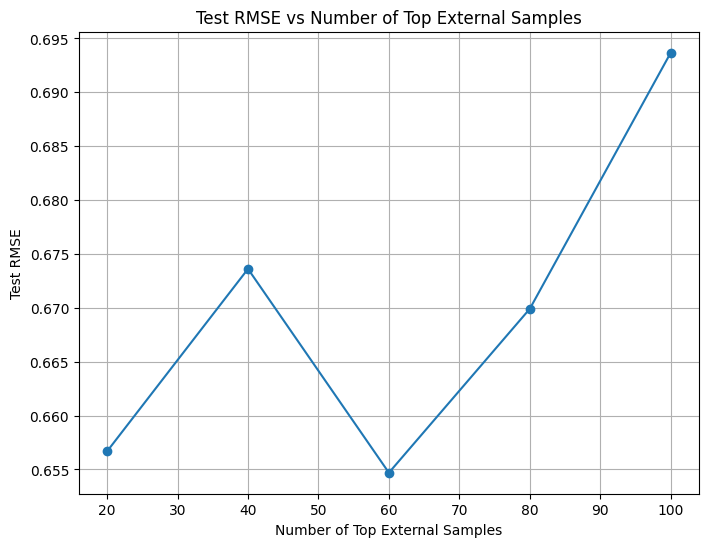

Best performing top_k value: 60


In [ ]:
# RMSE vs. Top-K
top_k_list = sorted(selection_results.keys())
rmse_list = [selection_results[k]["rmse"] for k in top_k_list]
plt.figure(figsize=(8,6))
plt.plot(top_k_list, rmse_list, marker="o")
plt.xlabel("Number of Top External Samples")
plt.ylabel("Test RMSE")
plt.title("Test RMSE vs Number of Top External Samples")
plt.grid(True)
plt.show()

# Determine the best top_k
best_top_k = min(selection_results, key=lambda k: selection_results[k]["rmse"])
print("Best performing top_k value:", best_top_k)


##Alternative Fine-tuning strategies

In [ ]:

best_external_data = selected_external_data_full[:best_top_k]
combined_train_data_best = original_train_data + best_external_data
combined_train_loader_best = DataLoader(combined_train_data_best, batch_size=16, shuffle=True)

def get_fresh_model():
    base_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)
    model = MoLFormerWithRegressionHead(base_model, hidden_dim=2362).to(device)
    return model


In [48]:
print(best_external_data[0])

{'input_ids': tensor([ 0,  4,  9,  4,  6, 12,  9,  7, 15,  8, 15, 11,  4,  4, 15,  6,  4, 16,
         8,  9,  4,  6, 12,  9,  7,  5,  8,  5,  5,  5,  5,  5,  8,  7, 10, 11,
         4,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, base_model, hidden_dim=2362):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.base_model = base_model
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        pooled_output = last_hidden_state[:, 0, :]
        return self.regression_head(pooled_output)

def get_fresh_model():
    base_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)
    model = MoLFormerWithRegressionHead(base_model, hidden_dim=2362).to(device)
    return model


### Fine-tuning strategies

In [ ]:
model_baseline = get_fresh_model().to(device)
optimizer_baseline = optim.AdamW(model_baseline.parameters(), lr=LR)
results_baseline = fine_tune_model(model_baseline, optimizer_baseline, combined_train_loader_best, test_loader)
print("Baseline Fine-Tuning Results:", results_baseline)

Epoch 1: 100%|██████████| 214/214 [00:13<00:00, 15.43it/s]


Epoch 1 Loss: 1.4861027940968488


Epoch 2: 100%|██████████| 214/214 [00:13<00:00, 15.47it/s]


Epoch 2 Loss: 0.7879242438857801


Epoch 3: 100%|██████████| 214/214 [00:13<00:00, 15.40it/s]


Epoch 3 Loss: 0.5701451921992213


Epoch 4: 100%|██████████| 214/214 [00:13<00:00, 15.52it/s]


Epoch 4 Loss: 0.4500247923848785


Epoch 5: 100%|██████████| 214/214 [00:13<00:00, 15.44it/s]


Epoch 5 Loss: 0.3617980962741041


Epoch 6: 100%|██████████| 214/214 [00:13<00:00, 15.33it/s]


Epoch 6 Loss: 0.32452263387146396


Epoch 7: 100%|██████████| 214/214 [00:13<00:00, 15.43it/s]


Epoch 7 Loss: 0.26710252965165077


Epoch 8: 100%|██████████| 214/214 [00:13<00:00, 15.38it/s]


Epoch 8 Loss: 0.2512810241396182


Epoch 9: 100%|██████████| 214/214 [00:13<00:00, 15.35it/s]


Epoch 9 Loss: 0.22327483598595468


Epoch 10: 100%|██████████| 214/214 [00:13<00:00, 15.45it/s]


Epoch 10 Loss: 0.20441472718370296
Baseline Fine-Tuning Results: {'mse': 0.5124118059690539, 'rmse': 0.7158294531304603, 'mae': 0.5604231072456709, 'r2': 0.6360661217383208}


In [ ]:
# 1. BitFit: Only update bias terms.
def apply_bitfit(model):
    for name, param in model.named_parameters():
        if "bias" not in name:
            param.requires_grad = False
    return model

In [47]:
model_bitfit = get_fresh_model().to(device)
model_bitfit = apply_bitfit(model_bitfit)
optimizer_bitfit = optim.AdamW(filter(lambda p: p.requires_grad, model_bitfit.parameters()), lr=LR)
results_bitfit = fine_tune_model(model_bitfit, optimizer_bitfit, combined_train_loader_best, test_loader)
print("BitFit Fine-Tuning Results:", results_bitfit)

Epoch 1: 100%|██████████| 214/214 [00:11<00:00, 18.43it/s]


Epoch 1 Loss: 2.528833590935324


Epoch 2: 100%|██████████| 214/214 [00:11<00:00, 18.65it/s]


Epoch 2 Loss: 1.8045299885986008


Epoch 3: 100%|██████████| 214/214 [00:11<00:00, 18.73it/s]


Epoch 3 Loss: 1.5105344110003143


Epoch 4: 100%|██████████| 214/214 [00:11<00:00, 18.45it/s]


Epoch 4 Loss: 1.4383288616331937


Epoch 5: 100%|██████████| 214/214 [00:12<00:00, 17.60it/s]


Epoch 5 Loss: 1.4077460375901694


Epoch 6: 100%|██████████| 214/214 [00:11<00:00, 18.60it/s]


Epoch 6 Loss: 1.3964893926526898


Epoch 7: 100%|██████████| 214/214 [00:11<00:00, 18.44it/s]


Epoch 7 Loss: 1.389600844026726


Epoch 8: 100%|██████████| 214/214 [00:11<00:00, 18.60it/s]


Epoch 8 Loss: 1.38019632206899


Epoch 9: 100%|██████████| 214/214 [00:11<00:00, 18.84it/s]


Epoch 9 Loss: 1.3705315550911092


Epoch 10: 100%|██████████| 214/214 [00:11<00:00, 18.64it/s]


Epoch 10 Loss: 1.3634156517893354
BitFit Fine-Tuning Results: {'mse': 1.3134935836672628, 'rmse': 1.1460774771660347, 'mae': 0.921695630551715, 'r2': 0.0671081181046641}


In [ ]:
# 2) LoRA
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha=1.0, bias=True):
        super(LoRALinear, self).__init__()
        self.r = r
        self.alpha = alpha
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None
        if r > 0:
            self.A = nn.Parameter(torch.randn(r, in_features))
            self.B = nn.Parameter(torch.randn(out_features, r))
        else:
            self.register_parameter("A", None)
            self.register_parameter("B", None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        if self.r > 0:
            nn.init.kaiming_uniform_(self.A, a=np.sqrt(5))
            nn.init.zeros_(self.B)

    def forward(self, x):
        # Standard linear output
        result = nn.functional.linear(x, self.weight, self.bias)
        if self.r > 0:
            # Ensure A and B are on the same device as x
            A_device = self.A.to(x.device)
            B_device = self.B.to(x.device)
            # Compute low-rank update
            BA = torch.mm(B_device, A_device)
            lora_update = self.alpha * nn.functional.linear(x, BA)
            result = result + lora_update
        return result

def replace_linear_with_lora(module, r=4, alpha=1.0):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear):
            in_features = child.in_features
            out_features = child.out_features
            bias = child.bias is not None
            # Create a LoRA layer with the same dimensions
            lora_layer = LoRALinear(in_features, out_features, r=r, alpha=alpha, bias=bias)
            # Initialize the LoRA layer with the original weights
            lora_layer.weight.data = child.weight.data.clone()
            if bias:
                lora_layer.bias.data = child.bias.data.clone()
            setattr(module, name, lora_layer)
        else:
            replace_linear_with_lora(child, r, alpha)

In [50]:
model_lora = get_fresh_model().to(device)
replace_linear_with_lora(model_lora.regression_head, r=4, alpha=1.0)
optimizer_lora = optim.AdamW(model_lora.parameters(), lr=LR)
results_lora = fine_tune_model(model_lora, optimizer_lora, combined_train_loader_best, test_loader)
print("LoRA Fine-Tuning Results:", results_lora)


Epoch 1: 100%|██████████| 214/214 [00:17<00:00, 12.42it/s]


Epoch 1 Loss: 1.5018299919701068


Epoch 2: 100%|██████████| 214/214 [00:16<00:00, 12.70it/s]


Epoch 2 Loss: 0.776063276158872


Epoch 3: 100%|██████████| 214/214 [00:16<00:00, 12.78it/s]


Epoch 3 Loss: 0.5687230101255613


Epoch 4: 100%|██████████| 214/214 [00:16<00:00, 12.73it/s]


Epoch 4 Loss: 0.4608132877500258


Epoch 5: 100%|██████████| 214/214 [00:16<00:00, 12.71it/s]


Epoch 5 Loss: 0.38441844900774064


Epoch 6: 100%|██████████| 214/214 [00:16<00:00, 12.75it/s]


Epoch 6 Loss: 0.33582739201243794


Epoch 7: 100%|██████████| 214/214 [00:16<00:00, 12.75it/s]


Epoch 7 Loss: 0.2865033818530702


Epoch 8: 100%|██████████| 214/214 [00:16<00:00, 12.74it/s]


Epoch 8 Loss: 0.25709438605982565


Epoch 9: 100%|██████████| 214/214 [00:16<00:00, 12.74it/s]


Epoch 9 Loss: 0.22120405559506373


Epoch 10: 100%|██████████| 214/214 [00:16<00:00, 12.80it/s]


Epoch 10 Loss: 0.2003229532356017
LoRA Fine-Tuning Results: {'mse': 0.42980215353720863, 'rmse': 0.6555929785600275, 'mae': 0.5029565831635237, 'r2': 0.6947385622269119}


In [ ]:
# 3. iA3: Implicit Adapter (simplified version).
class Adapter(nn.Module):
    def __init__(self, hidden_dim, adapter_dim=64):
        super(Adapter, self).__init__()
        self.adapter = nn.Sequential(
            nn.Linear(hidden_dim, adapter_dim),
            nn.ReLU(),
            nn.Linear(adapter_dim, hidden_dim)
        )
    def forward(self, x):
        return self.adapter(x)

def add_adapter(module, adapter_dim=64, device=None):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear):
            new_module = nn.Sequential(
                child,
                Adapter(child.out_features, adapter_dim)
            )
            if device is not None:
                new_module = new_module.to(device)
            setattr(module, name, new_module)
        else:
            add_adapter(child, adapter_dim, device)



In [52]:
model_ia3 = get_fresh_model().to(device)
add_adapter(model_ia3.regression_head, adapter_dim=64, device=device)
model_ia3 = model_ia3.to(device)
optimizer_ia3 = optim.AdamW(model_ia3.parameters(), lr=LR)
results_ia3 = fine_tune_model(model_ia3, optimizer_ia3, combined_train_loader_best, test_loader)
print("iA3 Fine-Tuning Results:", results_ia3)


Epoch 1: 100%|██████████| 214/214 [00:14<00:00, 15.09it/s]


Epoch 1 Loss: 1.2228043089124645


Epoch 2: 100%|██████████| 214/214 [00:14<00:00, 15.24it/s]


Epoch 2 Loss: 0.6411197202924256


Epoch 3: 100%|██████████| 214/214 [00:14<00:00, 15.17it/s]


Epoch 3 Loss: 0.46693415525499904


Epoch 4: 100%|██████████| 214/214 [00:14<00:00, 15.21it/s]


Epoch 4 Loss: 0.3739745284770137


Epoch 5: 100%|██████████| 214/214 [00:14<00:00, 15.24it/s]


Epoch 5 Loss: 0.3020359012080687


Epoch 6: 100%|██████████| 214/214 [00:14<00:00, 15.27it/s]


Epoch 6 Loss: 0.25347659531458516


Epoch 7: 100%|██████████| 214/214 [00:13<00:00, 15.32it/s]


Epoch 7 Loss: 0.22576111201719146


Epoch 8: 100%|██████████| 214/214 [00:13<00:00, 15.31it/s]


Epoch 8 Loss: 0.19399419966562886


Epoch 9: 100%|██████████| 214/214 [00:13<00:00, 15.30it/s]


Epoch 9 Loss: 0.16963441901466


Epoch 10: 100%|██████████| 214/214 [00:14<00:00, 15.18it/s]


Epoch 10 Loss: 0.1684018360955693
iA3 Fine-Tuning Results: {'mse': 0.4471886413034771, 'rmse': 0.6687216471024974, 'mae': 0.5037668067806711, 'r2': 0.6823900334685611}


## Plotting fine tune strategy results

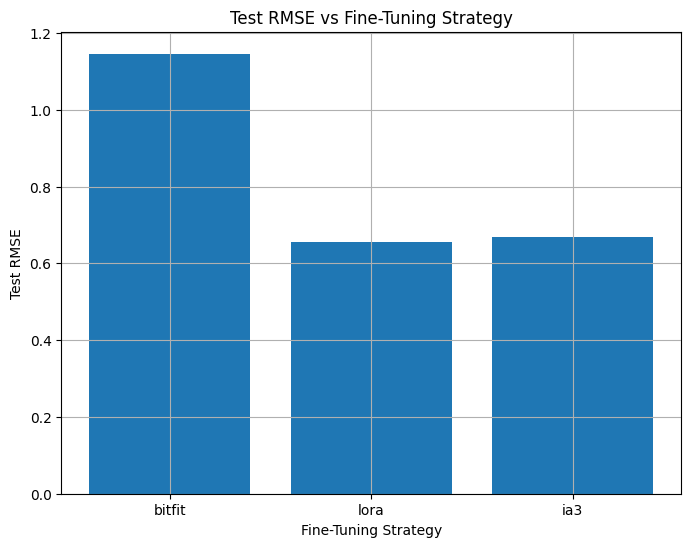

In [75]:
strategy_names = ["bitfit", "lora", "ia3"]
rmse_values = [results_bitfit["rmse"], results_lora["rmse"], results_ia3["rmse"]]

plt.figure(figsize=(8,6))
plt.bar(strategy_names, rmse_values)
plt.xlabel("Fine-Tuning Strategy")
plt.ylabel("Test RMSE")
plt.title("Test RMSE vs Fine-Tuning Strategy")
plt.grid(True)
plt.show()

In [ ]:
final_results = {
    "data_selection": selection_results,
    "fine_tuning": {
        "baseline": results_baseline,
        "bitfit": results_bitfit,
        "lora": results_lora,
        "ia3": results_ia3
    }
}

In [55]:
print("All experiments completed. Final results:")
print(final_results)

All experiments completed. Final results:
{'data_selection': {100: {'mse': 0.48118527657786125, 'rmse': 0.6936751953024277, 'mae': 0.5353300259337717, 'r2': 0.6582443616102479}, 80: {'mse': 0.448782049955668, 'rmse': 0.6699119717960472, 'mae': 0.5106878737919033, 'r2': 0.6812583355184116}, 60: {'mse': 0.4286315897040408, 'rmse': 0.6546996179195775, 'mae': 0.4954549964051694, 'r2': 0.6955699400964206}, 40: {'mse': 0.4537554430261513, 'rmse': 0.6736137194462055, 'mae': 0.5098318267824306, 'r2': 0.6777260472159636}, 20: {'mse': 0.4312359815049656, 'rmse': 0.6566856032417382, 'mae': 0.49904933676256663, 'r2': 0.6937202044002826}}, 'fine_tuning': {'baseline': {'mse': 0.5124118059690539, 'rmse': 0.7158294531304603, 'mae': 0.5604231072456709, 'r2': 0.6360661217383208}, 'bitfit': {'mse': 1.3134935836672628, 'rmse': 1.1460774771660347, 'mae': 0.921695630551715, 'r2': 0.0671081181046641}, 'lora': {'mse': 0.42980215353720863, 'rmse': 0.6555929785600275, 'mae': 0.5029565831635237, 'r2': 0.69473856

In [ ]:
import pandas as pd
import numpy as np

data_selection_results = []
for k, metrics in selection_results.items():
    data_selection_results.append({
         "Type": "Data Selection",
         "Top_K": k,
         "MSE": metrics["mse"],
         "RMSE": metrics["rmse"],
         "MAE": metrics["mae"],
         "R2": metrics["r2"]
    })

fine_tuning_results = []
for strategy, metrics in final_results["fine_tuning"].items():
    fine_tuning_results.append({
         "Type": "Fine-Tuning",
         "Strategy": strategy,
         "MSE": metrics["mse"],
         "RMSE": metrics["rmse"],
         "MAE": metrics["mae"],
         "R2": metrics["r2"]
    })

baseline_row = selection_results[40]

fine_tuning_results[0]['MSE'] = baseline_row['mse']
fine_tuning_results[0]['RMSE'] = baseline_row['rmse']
fine_tuning_results[0]['MAE'] = baseline_row['mae']
fine_tuning_results[0]['R2'] = baseline_row['r2']

df_selection = pd.DataFrame(data_selection_results)
df_finetuning = pd.DataFrame(fine_tuning_results)

df_combined = pd.concat([df_selection, df_finetuning], axis=0, ignore_index=True)

print("Data Selection Results:")
print(df_selection)
print("\nFine-Tuning Strategy Results:")
print(df_finetuning)
print("\nCombined Results:")
print(df_combined)


Data Selection Results:
             Type  Top_K       MSE      RMSE       MAE        R2
0  Data Selection    100  0.481185  0.693675  0.535330  0.658244
1  Data Selection     80  0.448782  0.669912  0.510688  0.681258
2  Data Selection     60  0.428632  0.654700  0.495455  0.695570
3  Data Selection     40  0.453755  0.673614  0.509832  0.677726
4  Data Selection     20  0.431236  0.656686  0.499049  0.693720

Fine-Tuning Strategy Results:
          Type  Strategy       MSE      RMSE       MAE        R2
0  Fine-Tuning  baseline  0.453755  0.673614  0.509832  0.677726
1  Fine-Tuning    bitfit  1.313494  1.146077  0.921696  0.067108
2  Fine-Tuning      lora  0.429802  0.655593  0.502957  0.694739
3  Fine-Tuning       ia3  0.447189  0.668722  0.503767  0.682390

Combined Results:
             Type  Top_K       MSE      RMSE       MAE        R2  Strategy
0  Data Selection  100.0  0.481185  0.693675  0.535330  0.658244       NaN
1  Data Selection   80.0  0.448782  0.669912  0.510688  0.681